# Buffer & Quality of Service Simulations - Mathematical Modelling Case Study

In [1]:
# IMPORT APPROPRIATE LIBRARIES #
import numpy as np
import matplotlib.pyplot as plt

## Partial Rejection Buffer Class

In [2]:
class partial_rejection_buffer:
    
    def __init__(self,lamb, mu, B, T, a, p):

        # GLOBALISE PARAMETERS #
        self.lamb = lamb; self.mu = mu; self.B = B;
        
        p_cum = np.cumsum(p) # cummulative distribution of probs of exponential mixture

        # SET PARAMETERS FOR LOOP #
        buff_property = {} # dictionary for storing all parameters
        elapsing = True # while loop parameter
        
        arrivals = np.array([]) # array for time between data arrivals
        job_size_array = np.array([])
        
        t_elapsed = 0 # time elapsed since t=0 (starts at 0)
        buff_state = 0 # current buffer state (starts at 0)
        num_rejected_job = 0
        rejected_data_size = 0

        # Arrays to store buffer occupancy & corresponding time points
        buff_plot = np.zeros(1)
        t_plot = np.zeros(1)

        # SIMULATE BUFFER WITH WHILE LOOP  #
        while elapsing:

            t_arrival = np.random.exponential(1/lamb) # sample time between data arrivals from exp dist

            if t_elapsed + t_arrival <= T: # make sure arrivals fall within the time range t specified

                p_finder = np.random.uniform()                      # select a random value in range [0,1]
                p_index = np.searchsorted(p_cum, p_finder, 'right') # use p_finder to find which exponential in mixture to sample from
                job_size = np.random.exponential(1/a[p_index])        # sample job size from chosen distribution
                job_size_array = np.append(job_size_array,job_size)

                if (max(buff_state - mu*t_arrival,0) + job_size) > B: # catch case of partially rejected job 
                    num_rejected_job += 1
                    diff = (max(buff_state - mu*t_arrival,0) + job_size) - B
                    rejected_data_size += diff

                if buff_state - mu * t_arrival < 0 : # catch case where buffer occupancy is 0 for plotting
                    t_interp = t_elapsed + buff_state/mu
                    t_plot = np.append(t_plot, t_interp)
                    buff_plot = np.append(buff_plot, 0)

                t_elapsed += t_arrival  # update current time
                arrivals = np.append(arrivals, t_arrival)

                t_plot = np.append(t_plot, t_elapsed)  
                buff_plot = np.append(buff_plot, max(buff_state - mu * t_arrival, 0))

                buff_state = min(B, max(buff_state - mu * t_arrival, 0) + job_size)  # find buffer state
                t_plot = np.append(t_plot, t_elapsed) 
                buff_plot = np.append(buff_plot, buff_state)

            else:

                elapsing = False # end loop when time elapsed exceeds final time T

                if buff_state - mu * (T - t_elapsed) < 0 : 

                    t_interp = t_elapsed + buff_state/mu
                    t_plot = np.append(t_plot, t_interp)
                    buff_plot = np.append(buff_plot, 0)

                    t_plot = np.append(t_plot, T)
                    buff_plot = np.append(buff_plot, 0)

                else:

                    final_buff_state = buff_state - mu * (T - t_elapsed) # find buffer state at final time t=T
                    t_plot = np.append(t_plot, T)  # Record the time point
                    buff_plot = np.append(buff_plot, final_buff_state)

        arrival_timestamp_list = np.cumsum(arrivals)
        buff_property["arrival_timestamp"] = arrival_timestamp_list
        buff_property["job_size"] = job_size_array
        buff_property["buff_occupancy_plot"] = buff_plot / B    
        buff_property['t_plot'] = t_plot

        self.buff_property = buff_property
        self.num_rejected_job = num_rejected_job
        self.rejected_data_size = rejected_data_size
        
    
    def plot(self):
        plt.plot(self.buff_property['t_plot'], self.buff_property["buff_occupancy_plot"])
        plt.xlabel('Time')
        plt.ylabel('Buffer Occupancy')
        plt.title(f'Buffer Occupancy Simulation for $B = {self.B}$ & $\mu = {self.mu}$')
        plt.show()
        
        
    def qos_delta(self):
        return self.num_rejected_job/(len(self.buff_property["job_size"]))
    
    
    def qos_epsilon(self):
        return self.rejected_data_size/self.buff_property["job_size"].sum()
    
    
    def qos_t_bar(self):
        return np.average(B*self.buff_property["buff_occupancy_plot"])/self.mu

## Full Rejection Buffer Class

In [3]:
class full_rejection_buffer(partial_rejection_buffer): # inherits functions from parent class
    
    def __init__(self,lamb, mu, B, T, a, p):

        # GLOBALISE PARAMETERS #
        self.lamb = lamb; self.mu = mu; self.B = B;
        
        p_cum = np.cumsum(p) # cummulative distribution of probs of exponential mixture
        
        # SET PARAMETERS FOR LOOP #
        buff_property = {} # dictionary for storing all parameters
        elapsing = True # while loop parameter
        
        arrivals = np.array([]) # array for time between data arrivals
        job_size_array = np.array([])
        
        t_elapsed = 0 # time elapsed since t=0 (starts at 0)
        buff_state = 0 # current buffer state (starts at 0)
        num_rejected_job = 0
        rejected_data_size = 0

        # Arrays to store buffer occupancy & corresponding time points
        buff_plot = np.zeros(1)
        t_plot = np.zeros(1)

        # SIMULATE BUFFER WITH WHILE LOOP  #
        while elapsing:

            t_arrival = np.random.exponential(1/lamb) # sample time between data arrivals from exp dist

            if t_elapsed + t_arrival <= T: # make sure arrivals fall within the time range t specified

                p_finder = np.random.uniform()                      # select a random value in range [0,1]
                p_index = np.searchsorted(p_cum, p_finder, 'right') # use p_finder to find which exponential in mixture to sample from
                job_size = np.random.exponential(1/a[p_index])        # sample job size from chosen distribution
                job_size_array = np.append(job_size_array,job_size)

                if (max(buff_state - mu*t_arrival,0) + job_size) > B: # catch case of rejected data 
                    num_rejected_job += 1
                    rejected_data_size += job_size
                    job_size = 0

                if buff_state - mu * t_arrival < 0 : # catch case where buffer occupancy is 0 for plotting
                    t_interp = t_elapsed + buff_state/mu
                    t_plot = np.append(t_plot, t_interp)
                    buff_plot = np.append(buff_plot, 0)

                t_elapsed += t_arrival  # update current time
                arrivals = np.append(arrivals, t_arrival)

                t_plot = np.append(t_plot, t_elapsed)  
                buff_plot = np.append(buff_plot, max(buff_state - mu * t_arrival, 0))

                buff_state = min(B, max(buff_state - mu * t_arrival, 0) + job_size)  # find buffer state
                t_plot = np.append(t_plot, t_elapsed) 
                buff_plot = np.append(buff_plot, buff_state)

            else:

                elapsing = False # end loop when time elapsed exceeds final time T

                if buff_state - mu * (T - t_elapsed) < 0 : 

                    t_interp = t_elapsed + buff_state/mu
                    t_plot = np.append(t_plot, t_interp)
                    buff_plot = np.append(buff_plot, 0)

                    t_plot = np.append(t_plot, T)
                    buff_plot = np.append(buff_plot, 0)

                else:

                    final_buff_state = buff_state - mu * (T - t_elapsed) # find buffer state at final time t=T
                    t_plot = np.append(t_plot, T)  # Record the time point
                    buff_plot = np.append(buff_plot, final_buff_state)

        arrival_timestamp_list = np.cumsum(arrivals)
        buff_property["arrival_timestamp"] = arrival_timestamp_list
        buff_property["job_size"] = job_size_array
        buff_property["buff_occupancy_plot"] = buff_plot / B    
        buff_property['t_plot'] = t_plot

        self.buff_property = buff_property
        self.num_rejected_job = num_rejected_job
        self.rejected_data_size = rejected_data_size

## Code Run

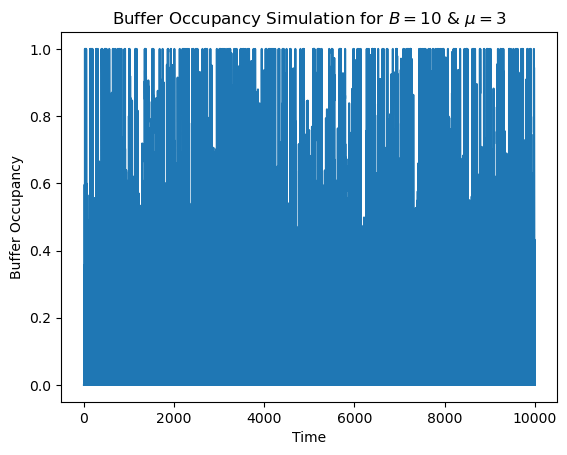

QoS - Proportion of jobs that need retransmission:
0.0272635814889336
QoS - Proportion of data that need retransmission:
0.040356952753080946
QoS - Average time a job has to wait before it begins transmission:
0.7067968315191876


In [4]:
# CHOOSE PARAMETERS #
lamb = 2; mu = 3; B = 10; T = 10000
a = [0.5,1.5,2]; p = [0.3,0.5,0.2] # mixture of exponential arrays, p must sum to 1

# RUN SIMULATION, PLOT, & FIND QoS MEASURES #
sim_partial = partial_rejection_buffer(lamb, mu, B, T, a, p)
sim_partial.plot()
print(f'QoS - Proportion of jobs that need retransmission:\n{sim_partial.qos_delta()}')
print(f'QoS - Proportion of data that need retransmission:\n{sim_partial.qos_epsilon()}')
print(f'QoS - Average time a job has to wait before it begins transmission:\n{sim_partial.qos_t_bar()}')

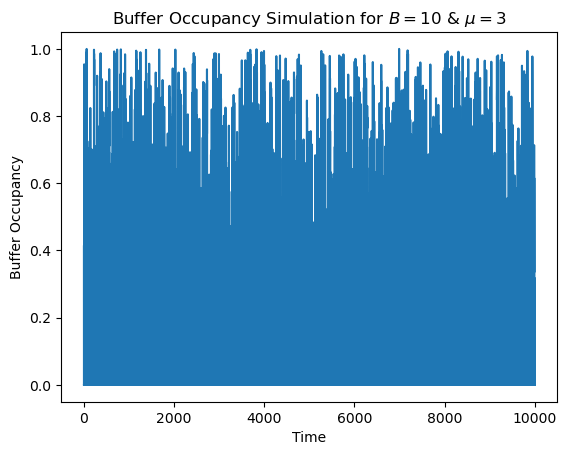

QoS - Proportion of jobs that need retransmission:
0.013379930104842735
QoS - Proportion of data that need retransmission:
0.07785313655680734
QoS - Average time a job has to wait before it begins transmission:
0.6240578653841689


In [5]:
# RUN SIMULATION, PLOT, & FIND QoS MEASURES #
sim_full = full_rejection_buffer(lamb, mu, B, T, a, p) # use same parameters as before
sim_full.plot()
print(f'QoS - Proportion of jobs that need retransmission:\n{sim_full.qos_delta()}')
print(f'QoS - Proportion of data that need retransmission:\n{sim_full.qos_epsilon()}')
print(f'QoS - Average time a job has to wait before it begins transmission:\n{sim_full.qos_t_bar()}')